In [1]:
import sys
sys.path.append('/workspace/Documents')
import os
import torch
import numpy as np 
import nibabel as nb
import Diffusion_denoising_thin_slice.denoising_diffusion_pytorch.denoising_diffusion_pytorch.conditional_diffusion as ddpm
import Diffusion_denoising_thin_slice.denoising_diffusion_pytorch.denoising_diffusion_pytorch.conditional_EDM as edm
import Diffusion_denoising_thin_slice.functions_collection as ff
import Diffusion_denoising_thin_slice.Build_lists.Build_list as Build_list
import Diffusion_denoising_thin_slice.Generator as Generator
from scipy.ndimage import gaussian_filter
from skimage.util import view_as_windows

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/Documents/Diffusion_models/denoising_diffusion_pytorch/denoising_diffusion_pytorch/standard_diffusion.py:773: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/workspace/Documents/Diffusion_models/denoising_diffusion_pytorch/denoising_diffusion_pytorch/conditional_diffusion.py:950: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/workspace/Documents/Diffusion_models/denoising_diffusion_pytorch/denoising_diffusion_pytorch/conditional_diffusion_3D.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `tor

In [3]:
build_sheet =  Build_list.Build(os.path.join('/mnt/camca_NAS/denoising/Patient_lists/fixedCT_static_simulation_train_test_gaussian.xlsx'))
_,patient_id_list,patient_subid_list,random_num_list, condition_list, x0_list = build_sheet.__build__(batch_list = [5]) 
n = ff.get_X_numbers_in_interval(total_number = patient_id_list.shape[0],start_number = 0,end_number = 1, interval = 3)
print('total number:', n.shape[0])

total number: 16


In [4]:
for i in range(0, n.shape[0]):
    patient_id = patient_id_list[n[i]]
    patient_subid = patient_subid_list[n[i]]
    print('patient_id:', patient_id, ' patient_subid:', patient_subid)

    folder = os.path.join('/mnt/camca_NAS/denoising/models/unsupervised_DDPM_gaussian_2D/pred_images',patient_id,patient_subid, 'random_0')
    folders = ff.find_all_target_files(['epoch70_*'],folder)
    # print('folders:', folders)

    total_n = len(folders)
    loaded_image = np.zeros([total_n, 512,512,50])

    for j in range(0,total_n):
        loaded_image[j] = nb.load(os.path.join(folders[j],'pred_img.nii.gz')).get_fdata()
    
    break


patient_id: 00214841  patient_subid: 0000455418


In [27]:
final_image_patch_weighted = np.zeros([512,512,50])
for i in range(0,3):#10):
    slice_range = [i * (loaded_image.shape[-1]//10), (i + 1) * (loaded_image.shape[-1]//10)]
    image= np.copy(loaded_image[:,:,:,slice_range[0]:slice_range[1]])/1000
    image = np.transpose(image, (1,2,3,0))
    print(image.shape)

    h,w,s,N = image.shape
    patch_size = (5,5,3)
    rH, rW, rS = patch_size[0] // 2, patch_size[1] // 2, patch_size[2] // 2
        # h_pad, w_pad = h + 2*r, w + 2*r

    # Step 1: Pad each sample image to handle border cases
    padded_stack = np.pad(image,
                          pad_width=((rH, rH), (rW, rW), (rS, rS), (0, 0)),
                          mode='constant',
                          constant_values=np.min(image))
    print('padded_stack shape:', padded_stack.shape)

    # Step 2: Extract patches for each pixel from each sample
    # For each of the 20 images, get view_as_windows: shape becomes [h, w, N, patch_size, patch_size]
    patches = np.stack([
        view_as_windows(padded_stack[:, :, :, k], patch_size)
        for k in range(N)
    ], axis=3)  # stack along sample axis
    print(patches.shape)

    # Step 3: Compute the mean patch across samples, shape: [h, w, patch_size, patch_size]
    mean_patch = np.mean(patches, axis=3)
    print('mean patch shape:', mean_patch.shape)

    # Step 4: Compute distance from each sample patch to the mean patch
    # Euclidean distance for each sample patch to the mean
    dists = np.sum((patches - mean_patch[:, :, :, None, :, :, :]) ** 2, axis=(-1, -2,-3))  # shape: [h, w, N]
    print('dists shape:', dists.shape)

    # Step 5: Convert distances to weights using Gaussian kernel
    h_param = 0.05  # bandwidth parameter, tune this
    weights = np.exp(-dists / (h_param ** 2))  # shape: [h, w, N]
    weights_sum = np.sum(weights, axis=3, keepdims=True)
    weights_sum[weights_sum == 0] = 1e-6  # avoid divide by zero
    weights /= weights_sum  # normalize weights, shape: [H, W, S, N]


    # Step 6: Weighted fusion: for each pixel location, do weighted sum over 20 samples
    fused_image_weighted = np.sum(image * weights, axis=3)  # shape: [h, w]
    print('fused image shape:', fused_image_weighted.shape)

    final_image_patch_weighted[:,:,slice_range[0]:slice_range[1]] = fused_image_weighted * 1000

(512, 512, 5, 20)
padded_stack shape: (516, 516, 7, 20)
(512, 512, 5, 20, 5, 5, 3)
mean patch shape: (512, 512, 5, 5, 5, 3)
dists shape: (512, 512, 5, 20)
fused image shape: (512, 512, 5)
(512, 512, 5, 20)
padded_stack shape: (516, 516, 7, 20)
(512, 512, 5, 20, 5, 5, 3)
mean patch shape: (512, 512, 5, 5, 5, 3)
dists shape: (512, 512, 5, 20)
fused image shape: (512, 512, 5)
(512, 512, 5, 20)
padded_stack shape: (516, 516, 7, 20)
(512, 512, 5, 20, 5, 5, 3)
mean patch shape: (512, 512, 5, 5, 5, 3)
dists shape: (512, 512, 5, 20)
fused image shape: (512, 512, 5)


In [5]:
affine = nb.load(os.path.join(folders[0],'pred_img.nii.gz')).affine
nb.save(nb.Nifti1Image(final_image_patch_weighted, affine), os.path.join(folder,'fused_image_patch_weighted.nii.gz'))

In [32]:
# simple average
final_image_avg = np.mean(loaded_image, axis=0)
nb.save(nb.Nifti1Image(final_image_avg, affine), os.path.join(folder,'fused_image_avg.nii.gz'))


In [18]:
## FFT
final_image_fft = np.zeros([512,512,50])

for slice_index in range(0,15):#loaded_image.shape[-1]):
    image = np.copy(loaded_image[:,:,:,slice_index])/1000
    image = np.transpose(image, (1,2,0))

    # Perform FFT
    fft_stack = np.fft.fft2(image, axes=(0, 1))
    fft_stack_shifted = np.fft.fftshift(fft_stack, axes=(0, 1))

    lowpass_mask = ff.create_2d_lowpass_mask((image.shape[0], image.shape[1]), radius=115)
    lowpass_mask = lowpass_mask[:,:,None]

    # Apply lowpass filter
    low_freq = fft_stack_shifted * lowpass_mask
    high_freq = fft_stack_shifted * (1 - lowpass_mask)

    low_freq = np.fft.ifftshift(low_freq, axes=(0,1))
    high_freq = np.fft.ifftshift(high_freq, axes=(0,1))

    low_fused = np.mean(low_freq, axis=2)    # mean over 20 samples
    high_fused = np.mean(high_freq, axis=2)

    fft_fused = low_fused + 0.5*high_fused
    fused_image = np.fft.ifftn(fft_fused, axes=(0, 1)).real * 1000

    final_image_fft[:,:,slice_index] = fused_image

In [19]:
nb.save(nb.Nifti1Image(final_image_fft, affine), os.path.join(folder,'fused_image_fft.nii.gz'))

lowpass mask shape: (512, 512)
log mag shape: (512, 512)  log mag masked shape: (512, 512)


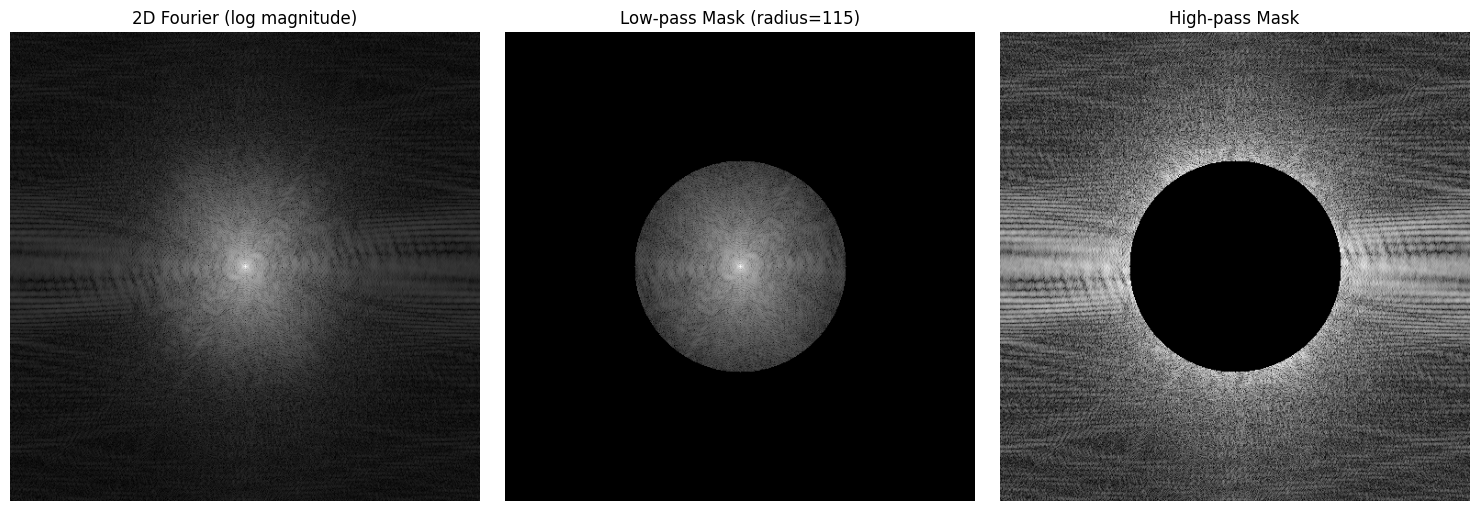

Low-pass mask ratio: 0.15848159790039062


In [22]:
import matplotlib.pyplot as plt
def visualize_2d_fft_and_mask(fft, radius):
    # image_slice: shape [H, W], raw image (float)
    # fft2 = np.fft.fftshift(np.fft.fft2(image_slice))
    log_mag = np.log1p(np.abs(fft))
    lowpass_mask = ff.create_2d_lowpass_mask((512, 512), radius=radius)  # shape [H, W, S]
    # lowpass_mask = lowpass_mask[..., None]  # shape [H, W, S, 1] → broadcast  
    print('lowpass mask shape:', lowpass_mask.shape) 
    # Apply mask
    fft_masked = fft * lowpass_mask
    log_mag_masked = np.log1p(np.abs(fft_masked)) 
    print('log mag shape:', log_mag.shape, ' log mag masked shape:', log_mag_masked.shape)

    high_fft_masked = fft* (1 - lowpass_mask)
    log_mag_high = np.log1p(np.abs(high_fft_masked))
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
   
    axes[0].imshow(log_mag, cmap='gray')
    axes[0].set_title("2D Fourier (log magnitude)")
    axes[1].imshow(log_mag_masked, cmap='gray')
    axes[1].set_title(f"Low-pass Mask (radius={radius})")
    axes[2].imshow(log_mag_high, cmap='gray')
    axes[2].set_title("High-pass Mask")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    return lowpass_mask

lowpass_mask = visualize_2d_fft_and_mask(fft_stack_shifted[:,:,0], radius=115)
print("Low-pass mask ratio:", np.mean(lowpass_mask))

In [17]:
print("Low-pass mask ratio:", np.mean(lowpass_mask))

Low-pass mask ratio: 0.2696266174316406
